# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [4]:
# !pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [19]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [6]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [7]:
!labelme

/bin/bash: line 1: labelme: command not found


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [1]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

### 2.2 Limit GPU Memory Growth

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2024-05-07 16:42:57.578776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-07 16:42:57.583729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-07 16:42:57.583888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TF Data Pipeline

In [4]:
data_wd = Path('/data') / 'raspi_face_detection'
img_path = data_wd / 'images'
labels_path = data_wd / 'labels'

In [5]:
images = tf.data.Dataset.list_files(f'{img_path}/*.jpg', shuffle=False)

2024-05-07 16:42:57.716037: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 16:42:57.717400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-07 16:42:57.717575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-07 16:42:57.717706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [6]:
images.as_numpy_iterator().next()

b'/data/raspi_face_detection/images/3560641c-0968-11ef-b027-dca632a68397.jpg'

In [7]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [8]:
images = images.map(load_image)

In [9]:
images.as_numpy_iterator().next()

array([[[149, 156, 166],
        [149, 156, 166],
        [149, 156, 166],
        ...,
        [145, 144, 140],
        [145, 144, 140],
        [144, 143, 139]],

       [[149, 156, 166],
        [149, 156, 166],
        [149, 156, 166],
        ...,
        [145, 144, 140],
        [145, 144, 140],
        [144, 143, 139]],

       [[149, 156, 166],
        [149, 156, 166],
        [149, 156, 166],
        ...,
        [144, 143, 139],
        [145, 144, 140],
        [146, 145, 141]],

       ...,

       [[ 92,  91,  89],
        [ 91,  90,  88],
        [ 91,  90,  88],
        ...,
        [ 41,  41,  43],
        [ 40,  40,  42],
        [ 40,  40,  42]],

       [[ 91,  90,  88],
        [ 91,  90,  88],
        [ 90,  89,  87],
        ...,
        [ 41,  41,  43],
        [ 41,  41,  43],
        [ 41,  41,  43]],

       [[ 92,  91,  89],
        [ 91,  90,  88],
        [ 91,  90,  88],
        ...,
        [ 41,  41,  43],
        [ 42,  42,  44],
        [ 42,  42,  44]]

In [10]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [11]:
image_generator = images.batch(4).as_numpy_iterator()

In [12]:
plot_images = image_generator.next()

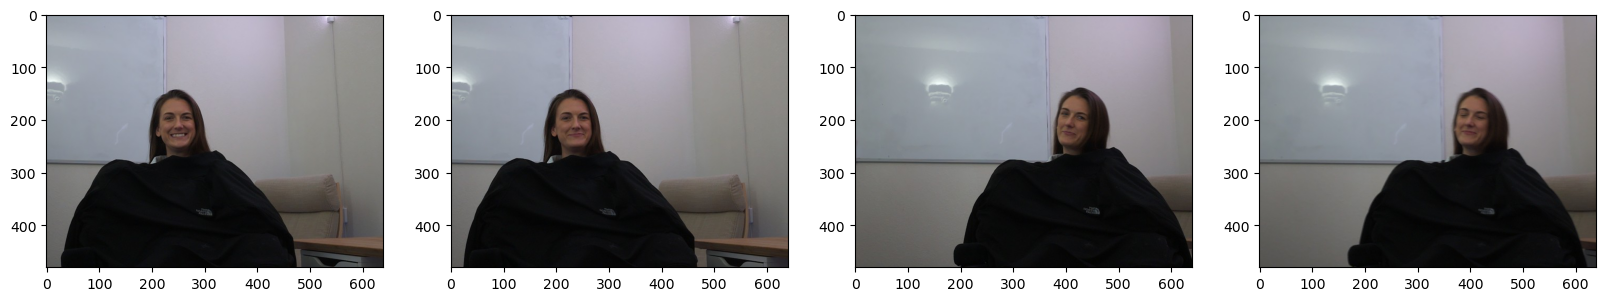

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [14]:
90*.7 # 63 to train

62.99999999999999

In [15]:
90*.15 # 14 and 13 to test and val

13.5

### 3.1.1 Programmatically Split Data into Train/Test/Val

In [16]:
from sklearn.model_selection import train_test_split
import json
import pandas as pd
import shutil

In [17]:
labels = list()
for label_fn in labels_path.glob('*'):
    with open(label_fn, 'r') as f:
        label_json = json.load(f)
    labels.append(dict(
        image_path=Path(label_json['imagePath']).name,
        labels=', '.join(sorted([x['label'] for x in label_json['shapes']]))
    ))

In [18]:
df_labels = pd.DataFrame(labels)
df_labels.labels.value_counts()

labels
brendan          60
kara             51
brendan, kara     9
Name: count, dtype: int64

In [19]:
train, test = train_test_split(df_labels, test_size=0.3, random_state=42, stratify=df_labels.labels)
test, val = train_test_split(test, test_size=0.5, random_state=42, stratify=test.labels)

In [20]:
print('Training Set')
print(train.labels.value_counts().to_string(header=False))
print('\nTest Set')
print(test.labels.value_counts().to_string(header=False))
print('\nValidation Set')
print(val.labels.value_counts().to_string(header=False))

Training Set
brendan          42
kara             36
brendan, kara     6

Test Set
brendan          9
kara             8
brendan, kara    1

Validation Set
brendan          9
kara             7
brendan, kara    2


In [21]:
model_sets_files = dict(
    train=train.image_path.tolist(),
    test=test.image_path.tolist(),
    val=val.image_path.tolist(),
)
print('Model Set Percentages Check')
print({k: len(v) for k, v in model_sets_files.items()})
print({k: len(v) / len(df_labels) for k, v in model_sets_files.items()})

Model Set Percentages Check
{'train': 84, 'test': 18, 'val': 18}
{'train': 0.7, 'test': 0.15, 'val': 0.15}


### 3.2 Moving Images and Labels

In [22]:
model_sets_path = data_wd / 'model_sets'

In [23]:
list(model_sets_path.glob('*'))

[PosixPath('/data/raspi_face_detection/model_sets/val'),
 PosixPath('/data/raspi_face_detection/model_sets/train'),
 PosixPath('/data/raspi_face_detection/model_sets/test')]

In [24]:
folder = 'train'
model_set_filepath = model_sets_path / folder
model_set_filepath_images = model_set_filepath / 'images'
model_set_filepath_labels = model_set_filepath / 'labels'
for p in [model_set_filepath, model_set_filepath_images, model_set_filepath_labels]:
    p.mkdir(exist_ok=True)

In [25]:
# for folder in ['train','test','val']:
#     model_set_filepath = model_sets_path / folder
#     model_set_filepath_images = model_set_filepath / 'images'
#     model_set_filepath_labels = model_set_filepath / 'labels'
#     for p in [model_set_filepath, model_set_filepath_images, model_set_filepath_labels]:
#         p.mkdir(exist_ok=True)

#     for img_filename in model_sets_files[folder]:
#         src_img_filepath, dst_img_filepath = [p / img_filename for p in [img_path, model_set_filepath_images]]
#         shutil.copyfile(src_img_filepath, dst_img_filepath)
        
#         label_filename = img_filename.split('.')[0]+'.json'
#         src_label_filepath, dst_label_filepath = [p / label_filename for p in [labels_path, model_set_filepath_labels]]
#         shutil.copyfile(src_label_filepath, dst_label_filepath)

# 4. Apply Image Augmentation on Images and Labels using Albumentations

In [26]:
import albumentations as alb
import cv2

### 4.1 Setup Albumentations Transform Pipeline

In [27]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                         bbox_params=alb.BboxParams(format='albumentations', 
                                                    label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [28]:
fns = list(model_set_filepath_images.glob('*'))
# fn = fns[1].stem
fn = '49e246c6-0968-11ef-b027-dca632a68397'
fn

'49e246c6-0968-11ef-b027-dca632a68397'

In [29]:
model_sets_path

PosixPath('/data/raspi_face_detection/model_sets')

In [30]:
img_fn   = model_sets_path / 'train' / 'images' / f'{fn}.jpg'
label_fn = model_sets_path / 'train' / 'labels' / f'{fn}.json'

In [31]:
img = cv2.imread(str(img_fn))
print(('height', 'width', 'layers'))
img.shape

('height', 'width', 'layers')


(480, 640, 3)

In [32]:
with open(label_fn, 'r') as f:
    label = json.load(f)

In [33]:
label.keys()

dict_keys(['version', 'flags', 'shapes', 'imagePath', 'imageData', 'imageHeight', 'imageWidth'])

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [34]:
# coords = [0,0,0,0]
# shapes = label['shapes']
# points = shapes[0]['points']
# coords[0] = points[0][0]
# coords[1] = points[0][1]
# coords[2] = points[1][0]
# coords[3] = points[1][1]

# label = shapes[0]['label']

# print(['p1-width', 'p1-height', 'p2-width', 'p2-height'])
# print(coords)

# print("\n\np1 = top-left point")
# print("p2 = lower-right point")

In [35]:
# coords = list(np.divide(coords, [640,480,640,480]))

In [36]:
shapes, coords, labels = label['shapes'], list(), list()
for shape in shapes:
    c = [0,0,0.00001,0.00001]
    c[0] = shape['points'][0][0]
    c[1] = shape['points'][0][1]
    c[2] = shape['points'][1][0]
    c[3] = shape['points'][1][1]
    c = list(np.divide(c, [640,480,640,480]))

    labels.append(shape['label'])
    coords.append(c)
coords, labels

([[0.3280038759689923,
   0.2678456072351422,
   0.5006056201550387,
   0.5294735142118864],
  [0.11543120155038762,
   0.06597222222222227,
   0.2704699612403101,
   0.3235626614987081]],
 ['kara', 'brendan'])

### 4.4 Apply Augmentations and View Results

In [37]:
augmented = augmentor(image=img, bboxes=coords, class_labels=labels)

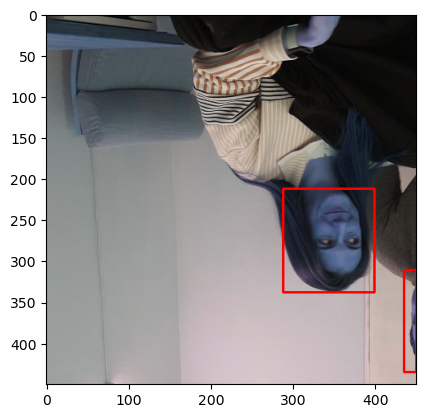

In [38]:
for bbox in augmented['bboxes']:
    cv2.rectangle(augmented['image'], 
                  tuple(np.multiply(bbox[:2], [450,450]).astype(int)),
                  tuple(np.multiply(bbox[2:], [450,450]).astype(int)), 
                        (255,0,0), 2)

plt.imshow(augmented['image'])

### 4.5 Find Issues where x_max is less than or equal to x_min

In [39]:
errors = list()

fns = list(img_path.glob('*'))
for fn in fns:
    stem = fn.stem
    img_fn   = img_path / f'{stem}.jpg'
    label_fn = labels_path / f'{stem}.json'
    
    
    img = cv2.imread(str(img_fn))
    with open(label_fn, 'r') as f:
        label = json.load(f)
    
    shapes = label['shapes']
    for shape in shapes:
        coords = [0,0,0,0]
        points = shape['points']
        coords[0] = points[0][0]
        coords[1] = points[0][1]
        coords[2] = points[1][0]
        coords[3] = points[1][1]
        coords = list(np.divide(coords, [640,480,640,480]))
    
        try:
            augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
        except ValueError:
            errors.append([stem, shape['label']])

print(len(errors))

0


In [40]:
print(pd.DataFrame(errors).to_csv())

""



# 5. Build and Run Augmentation Pipeline

In [41]:
aug_sets_path = data_wd / 'aug_data'

### 5.1 Run Augmentation Pipeline

In [42]:
# class_nums = dict(brendan=1, kara=2)

# for partition in ['train','test','val']: 
#     model_set_filepath = model_sets_path / partition
#     model_set_filepath_images = model_set_filepath / 'images'
#     model_set_filepath_labels = model_set_filepath / 'labels'

#     aug_set_filepath = aug_sets_path / partition
#     aug_set_filepath_images = aug_set_filepath / 'images'
#     aug_set_filepath_labels = aug_set_filepath / 'labels'
    
#     for image in list(model_set_filepath_images.glob('*')):
#         img_path = model_set_filepath_images / image
#         img = cv2.imread(str(img_path))

#         label_path = model_set_filepath_labels / f'{img_path.stem}.json'
#         if label_path.is_file():
#             with open(label_path, 'r') as f:
#                 label = json.load(f)

#         shapes, coords, labels = label['shapes'], list(), list()
#         shapes.sort(key=lambda x: x['label'])
#         for shape in shapes:
#             c = [0,0,0.00001,0.00001]
#             c[0] = shape['points'][0][0]
#             c[1] = shape['points'][0][1]
#             c[2] = shape['points'][1][0]
#             c[3] = shape['points'][1][1]
#             c = list(np.divide(c, [640,480,640,480]))
        
#             labels.append(shape['label'])
#             coords.append(c)


#         for x in range(60):
#             augmented = augmentor(image=img, bboxes=coords, class_labels=labels)
#             aug_image, aug_labels, aug_bboxes = augmented['image'], augmented['class_labels'], augmented['bboxes']
            
#             cv2.imwrite(str(aug_set_filepath_images / f'{img_path.stem}_{x}.jpg'), aug_image)

#             annotation = {}
#             annotation['image'] = str(image)

#             if not label_path.is_file() or len(aug_labels) == 0: 
#                 annotation['bboxes'] = [[0,0,0,0], [0,0,0,0]]
#                 annotation['classes'] = [0] 
#             else:
#                 if len(aug_labels) == 1:
#                     if aug_labels[0] == 'kara':
#                         aug_bboxes.insert(0, (0, 0, 0, 0))
#                     else:
#                         aug_bboxes.append((0, 0, 0, 0))
                        
#                 assert len(aug_bboxes) == 2
#                 assert len(aug_bboxes[0]) == 4
#                 assert len(aug_bboxes[1]) == 4
                
#                 annotation['bboxes'] = aug_bboxes
#                 annotation['classes'] = list(map(lambda x: class_nums[x], aug_labels))
#                 # Add new code here
                    


#             with open(str(aug_set_filepath_labels / f'{img_path.stem}_{x}.json'), 'w') as f:
#                 json.dump(annotation, f)

In [43]:
for partition in ['train','test','val']: 
    aug_set_filepath = aug_sets_path / partition
    aug_set_filepath_images = aug_set_filepath / 'images'
    aug_set_filepath_labels = aug_set_filepath / 'labels'

    cnt_images, cnt_labels = len(list(aug_set_filepath_images.glob('*'))), len(list(aug_set_filepath_labels.glob('*')))

    print(f'{partition} augmentation set' + '\n' + '-'*10)
    print(f'{cnt_images} Images & {cnt_labels} Labels\n\n')

train augmentation set
----------
5040 Images & 5040 Labels


test augmentation set
----------
1080 Images & 1080 Labels


val augmentation set
----------
1080 Images & 1080 Labels




### 5.2 Load Augmented Images to Tensorflow Dataset

In [44]:
train_images = tf.data.Dataset.list_files(str(aug_sets_path / 'train' / 'images'/ '*.jpg'), shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [45]:
test_images = tf.data.Dataset.list_files(str(aug_sets_path / 'test' / 'images'/ '*.jpg'), shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [46]:
val_images = tf.data.Dataset.list_files(str(aug_sets_path / 'val' / 'images'/ '*.jpg'), shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [47]:
train_images.as_numpy_iterator().next()

array([[[0.3617647 , 0.35539216, 0.35490197],
        [0.36372548, 0.35980392, 0.3509804 ],
        [0.36813724, 0.36421567, 0.3485294 ],
        ...,
        [0.05196078, 0.05196078, 0.05980392],
        [0.05343137, 0.05343137, 0.06127451],
        [0.05036765, 0.05036765, 0.05821078]],

       [[0.36078432, 0.36078432, 0.3529412 ],
        [0.36825982, 0.36433825, 0.3564951 ],
        [0.37555146, 0.3716299 , 0.35594362],
        ...,
        [0.05882353, 0.05882353, 0.06666667],
        [0.05833333, 0.05833333, 0.06617647],
        [0.06066176, 0.05821078, 0.07340686]],

       [[0.3720588 , 0.3720588 , 0.36421567],
        [0.38382354, 0.37990198, 0.3720588 ],
        [0.3759804 , 0.3720588 , 0.36421567],
        ...,
        [0.0627451 , 0.0627451 , 0.07058824],
        [0.05882353, 0.05882353, 0.06666667],
        [0.05557598, 0.053125  , 0.06832108]],

       ...,

       [[0.6117647 , 0.6392157 , 0.67058825],
        [0.6152574 , 0.64270836, 0.6740809 ],
        [0.61519605, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [48]:
import itertools

In [49]:
# fn = '49e246c6-0968-11ef-b027-dca632a68397_5.json' # both
# fn = '3a38b642-0968-11ef-b027-dca632a68397_4.json' # kara
# fn = '4a2f0b44-0965-11ef-a3f3-dca632a68397_37.json' # brendan
fn = '369aab30-0968-11ef-b027-dca632a68397_0.json' # error
label_path = aug_sets_path / 'train' / 'labels' / fn
with open(label_path, 'r', encoding = "utf-8") as f:
    label = json.load(f)

label['classes'], label['bboxes']

([2],
 [[0, 0, 0, 0],
  [0.39486649440137817,
   0.46933677863910417,
   0.6300086132644273,
   0.7329026701119724]])

In [50]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [int(x in label['classes']) for x in range(1, 3)], list(itertools.chain(*label['bboxes']))

# classes, bboxes = load_labels(label_path)

### 6.2 Load Labels to Tensorflow Dataset

In [51]:
train_labels = tf.data.Dataset.list_files(str(aug_sets_path / 'train' / 'labels'/ '*.json'), shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [52]:
test_labels = tf.data.Dataset.list_files(str(aug_sets_path / 'test' / 'labels'/ '*.json'), shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [53]:
val_labels = tf.data.Dataset.list_files(str(aug_sets_path / 'val' / 'labels'/ '*.json'), shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [54]:
train_labels.as_numpy_iterator().next()

(array([0, 1], dtype=uint8),
 array([0.    , 0.    , 0.    , 0.    , 0.3948, 0.4692, 0.63  , 0.733 ],
       dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [55]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5040, 5040, 1080, 1080, 1080, 1080)

### 7.2 Create Final Datasets (Images/Labels)

In [56]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(16)
train = train.prefetch(4)

In [99]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(16)
test = test.prefetch(4)

In [58]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(16)
val = val.prefetch(4)

### 7.3 View Images and Annotations

In [59]:
data_samples = train.as_numpy_iterator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


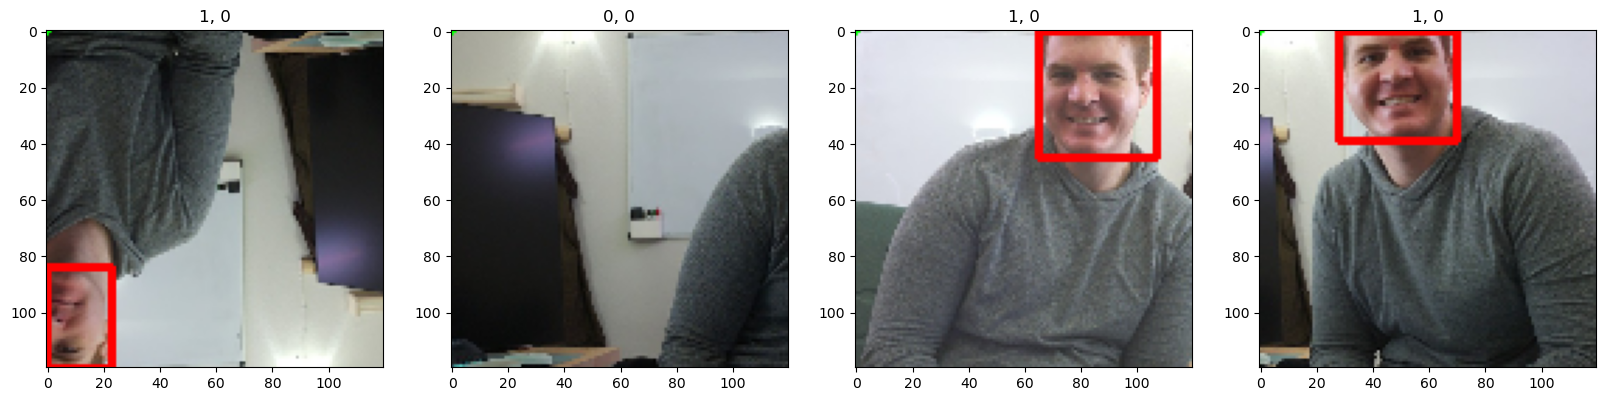

In [60]:
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    sample_labels = ', '.join(res[1][0][idx].astype(str).tolist())

    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[0:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:4], [120,120]).astype(int)), (255,0,0), 2)
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[4:6], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[6:8], [120,120]).astype(int)), (0,255,0), 2)

    ax[idx].imshow(sample_image)
    ax[idx].set_title(sample_labels)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [61]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [62]:
vgg = VGG16(include_top=False)

In [63]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [64]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(2, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(8, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [65]:
facetracker = build_model()

In [66]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [67]:
X, y = train.as_numpy_iterator().next()

In [68]:
X.shape

(16, 120, 120, 3)

In [69]:
classes, coords = facetracker.predict(X)

2024-05-07 16:43:22.120588: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8902
2024-05-07 16:43:22.186901: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-07 16:43:22.187182: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-07 16:43:22.187197: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-05-07 16:43:22.187613: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-07 16:43:22.187641: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-07 16:43:22.526038: I tensorflow/stream_executor/cuda/c

In [70]:
classes, coords

(array([[0.66944134, 0.42906243],
        [0.6038352 , 0.3382603 ],
        [0.6507173 , 0.4026134 ],
        [0.6309252 , 0.45589092],
        [0.6299129 , 0.42999864],
        [0.6920435 , 0.4364452 ],
        [0.67754024, 0.3929911 ],
        [0.6581239 , 0.3560058 ],
        [0.6767964 , 0.469536  ],
        [0.62670445, 0.50225836],
        [0.6433703 , 0.35290432],
        [0.5945358 , 0.41397744],
        [0.55431765, 0.38689858],
        [0.679891  , 0.3862347 ],
        [0.59829736, 0.40434963],
        [0.62093365, 0.40190053]], dtype=float32),
 array([[0.6047082 , 0.4692748 , 0.5981452 , 0.5438252 , 0.5000464 ,
         0.51225555, 0.4364515 , 0.44564086],
        [0.59186953, 0.5000729 , 0.6146848 , 0.46459308, 0.4106255 ,
         0.46075583, 0.47776058, 0.4538922 ],
        [0.523232  , 0.40276685, 0.6231959 , 0.49906808, 0.5599488 ,
         0.45096105, 0.39142653, 0.35496315],
        [0.5864621 , 0.39712086, 0.7016359 , 0.5006833 , 0.46475214,
         0.47857428, 0.52

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [71]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch
lr_decay

0.001058201058201058

In [73]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00005, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [74]:
def localization_loss(y_true, yhat):
    # differences between coordinates
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2])) + tf.reduce_sum(tf.square(y_true[:,4:6] - yhat[:,4:6]))

    # differences between size
    delta_size = 0
    for i in range(2):
        h_true = y_true[:,3+4*i] - y_true[:,1+4*i] 
        w_true = y_true[:,2+4*i] - y_true[:,0+4*i] 
    
        h_pred = yhat[:,3+4*i] - yhat[:,1+4*i] 
        w_pred = yhat[:,2+4*i] - yhat[:,0+4*i] 
        
        delta_size += tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [75]:
y_true = [0]*8
y_true

[0, 0, 0, 0, 0, 0, 0, 0]

In [76]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [77]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=14.505406>

In [78]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7989988>

In [79]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=14.505406>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [80]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [81]:
model = FaceTracker(facetracker)

In [82]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [83]:
logdir='logs'

In [84]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [85]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
315/315 [==============================] - 11s 26ms/step - total_loss: 1.0325 - class_loss: 0.0966 - regress_loss: 0.9842 - val_total_loss: 1.1236 - val_class_loss: 0.5113 - val_regress_loss: 0.8680
Epoch 2/20
315/315 [==============================] - 9s 25ms/step - total_loss: 0.2128 - class_loss: 0.0178 - regress_loss: 0.2039 - val_total_loss: 0.2184 - val_class_loss: 0.0320 - val_regress_loss: 0.2024
Epoch 3/20
315/315 [==============================] - 9s 25ms/step - total_loss: 0.1508 - class_loss: 0.0132 - regress_loss: 0.1442 - val_total_loss: 0.8170 - val_class_loss: 0.3781 - val_regress_loss: 0.6279
Epoch 4/20
315/315 [==============================] - 9s 25ms/step - total_loss: 0.1099 - class_loss: 0.0085 - regress_loss: 0.1057 - val_total_loss: 1.0241 - val_class_loss: 0.5334 - val_regress_loss: 0.7574
Epoch 5/20
315/315 [==============================] - 9s 24ms/step - total_loss: 0.0884 - class_loss: 0.0063 - regress_loss: 0.0853 - val_total_loss: 1.6916 - val_

### 10.3 Plot Performance

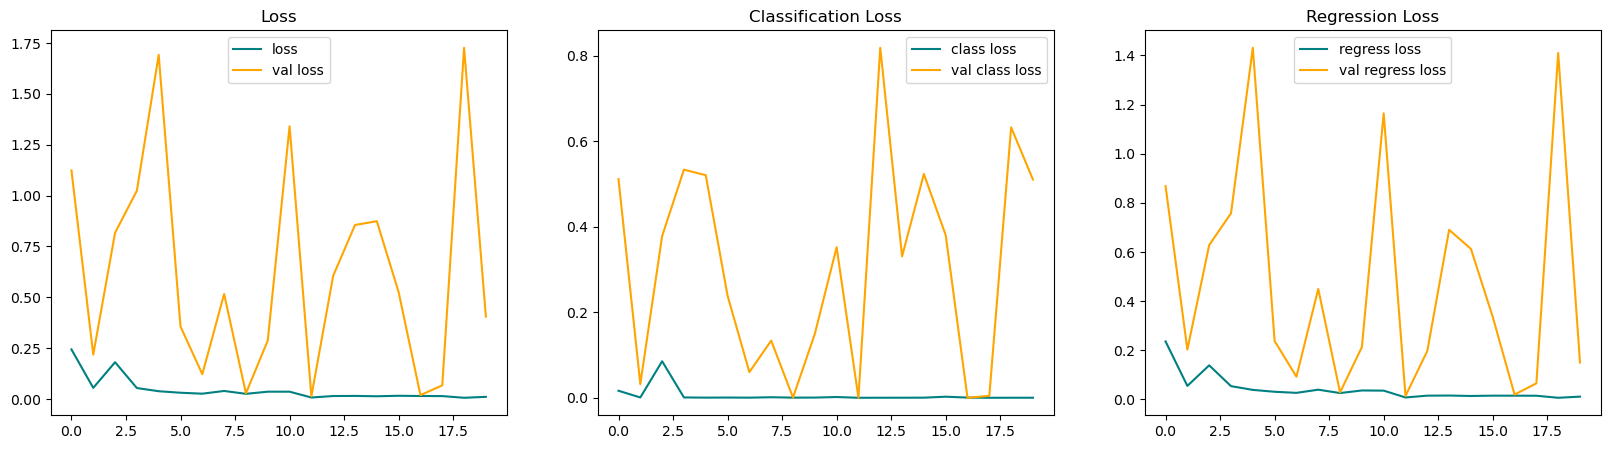

In [86]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [100]:
test_data = test.as_numpy_iterator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


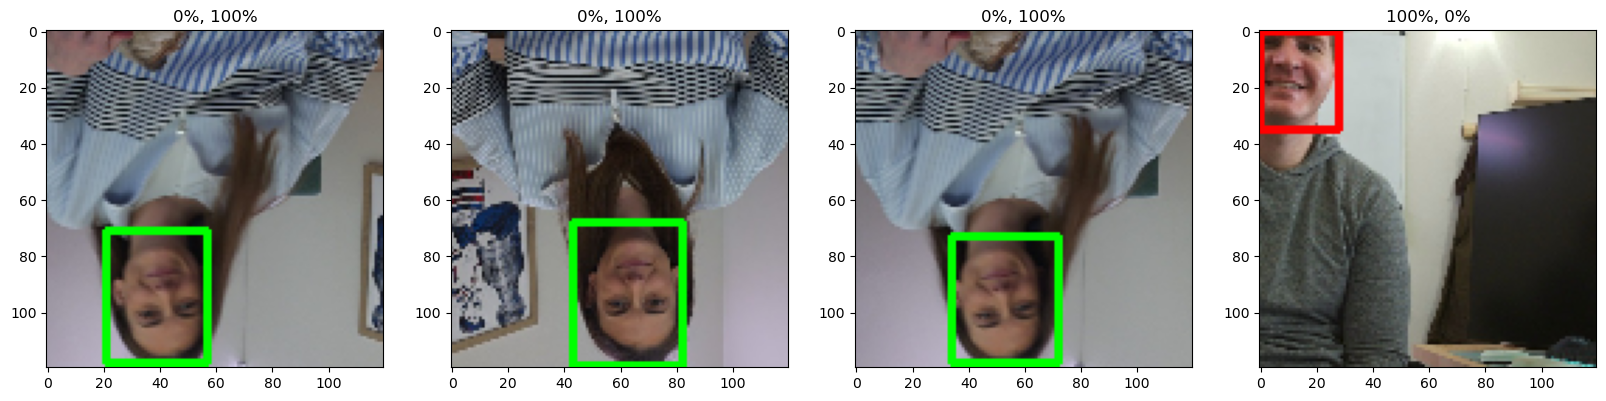

In [102]:
test_sample = test_data.next()

yhat = facetracker.predict(test_sample[0])

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx][0] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[0:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:4], [120,120]).astype(int)), (255,0,0), 2)
    if yhat[0][idx][1] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[4:6], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[6:8], [120,120]).astype(int)), (0,255,0), 2)
    
    ax[idx].imshow(sample_image)
    ax[idx].set_title(', '.join([f'{x:,.0%}' for x in yhat[0][idx]]))

### 11.2 Save the Model

In [103]:
from tensorflow.keras.models import load_model
import cv2
import tensorflow as tf
import numpy as np

In [106]:
# facetracker.save('facetracker.h5')

In [4]:
facetracker = load_model('facetracker.h5')

2024-05-07 15:22:11.629106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-07 15:22:11.634456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-07 15:22:11.634617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-07 15:22:11.634976: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

#### 11.2.1 Single Photo

In [185]:
# cap = cv2.VideoCapture(0)
# _, frame_captured = cap.read()

In [249]:
final_test_wd = data_wd / 'final_test_images'
img_gen = final_test_wd.glob('*.jpg')

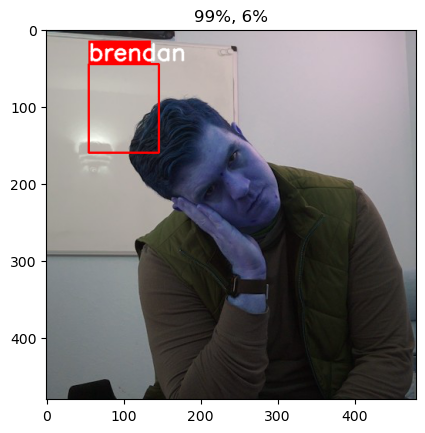

In [261]:
frame_captured = cv2.imread(str(next(img_gen)))
plt.imshow(frame_captured)

frame = frame_captured[:, 80:640-80,:]

rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
resized = tf.image.resize(rgb, (120,120))

yhat = facetracker.predict(np.expand_dims(resized/255,0))
labels, sample_coords = [x[0] for x in yhat]
labels, sample_coords

if yhat[0][0][0] > 0.4:
    # Controls the main rectangle
    cv2.rectangle(frame, 
                  tuple(np.multiply(sample_coords[0:2], [450,450]).astype(int)),
                  tuple(np.multiply(sample_coords[2:4], [450,450]).astype(int)), 
                        (255,0,0), 2)
    # Controls the label rectangle
    cv2.rectangle(frame, 
                  tuple(np.add(np.multiply(sample_coords[0:2], [450,450]).astype(int), 
                                [0,-30])),
                  tuple(np.add(np.multiply(sample_coords[0:2], [450,450]).astype(int),
                                [80,0])), 
                        (255,0,0), -1)
    # Controls the text rendered
    cv2.putText(frame, 'brendan', tuple(np.add(np.multiply(sample_coords[0:2], [450,450]).astype(int),
                                           [0,-5])),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
if yhat[0][0][1] > 0.4:
    # Controls the main rectangle
    cv2.rectangle(frame, 
                  tuple(np.multiply(sample_coords[4:6], [450,450]).astype(int)),
                  tuple(np.multiply(sample_coords[6:8], [450,450]).astype(int)), 
                        (255,0,0), 2)
    # Controls the label rectangle
    cv2.rectangle(frame, 
                  tuple(np.add(np.multiply(sample_coords[4:6], [450,450]).astype(int), 
                                [0,-30])),
                  tuple(np.add(np.multiply(sample_coords[4:6], [450,450]).astype(int),
                                [80,0])), 
                        (255,0,0), -1)
    
    # Controls the text rendered
    cv2.putText(frame, 'kara', tuple(np.add(np.multiply(sample_coords[4:6], [450,450]).astype(int),
                                           [0,-5])),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

im = plt.imshow(frame)
im.axes.set_title(', '.join([f'{x:,.0%}' for x in labels]))
plt.show()

### 11.3 Real Time Detection

In [137]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0][0][0] > 0.9:
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[0:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:4], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[0:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[0:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        # Controls the text rendered
        cv2.putText(frame, 'brendan', tuple(np.add(np.multiply(sample_coords[0:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    if yhat[0][0][0] > 0.9:
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[4:6], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[6:8], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[4:6], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[4:6], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'kara', tuple(np.add(np.multiply(sample_coords[4:6], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 